In [1]:
include("utils.jl")
using .Utils

┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.0/Makie/iZ1Bl.ji for Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.0/Flux/QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1190


In [2]:
using Flux
using LightGraphs
using GraphPlot
using Makie
using Colors
using Juno
using Statistics

┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.0/LightGraphs/Xm08G.ji for LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.0/GraphPlot/bUwXr.ji for GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1190


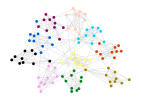

In [3]:
l = 10
k = 10
g = LightGraphs.SimpleGraphs.stochastic_block_model(0.8 * k, .2, k .* ones(UInt, l), seed = 1)
communities = [c for c in 1:l for i in 1:k]
features = Flux.normalise(Flux.onehotbatch(communities, 1:l))

palette = distinguishable_colors(l)
colors = map(i -> getindex(palette, i), communities)
gplot(g, nodefillc = colors)

In [4]:
palette

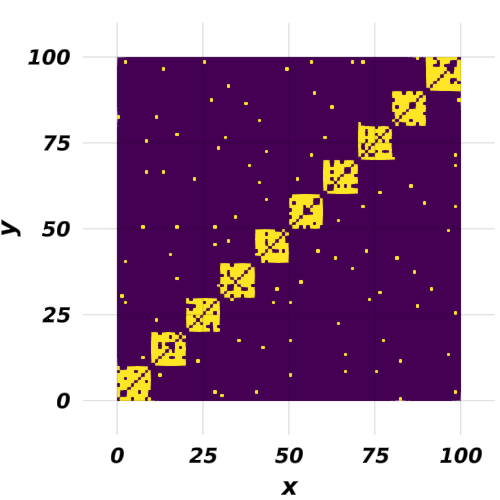

In [5]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, Array(adjacency_matrix(g)))

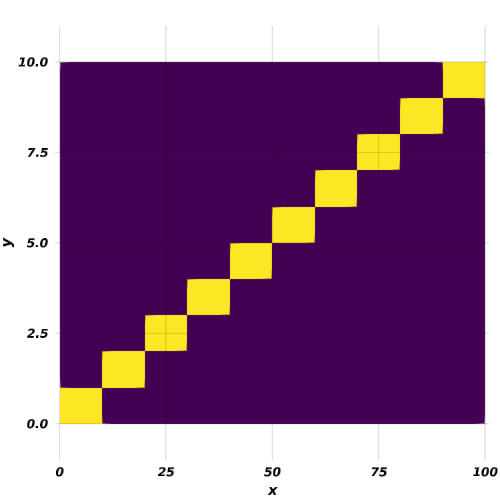

In [6]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, features)

In [7]:
module Layers


using Flux
using LinearAlgebra
using LightGraphs

nobias(out::Integer) = fill(nothing, out)
Flux.param(n::AbstractArray{Nothing}) = 0

adjacency_matrix_diag(g) = adjacency_matrix(g) + Matrix(I, size(g)...)

struct GC{T,U,F}
    Â::AbstractArray
    W::T
    b::U
    σ::F
    function GC(g::SimpleGraph, W::T, b::U, σ::F) where {T,U,F}
        Ã = adjacency_matrix_diag(g)
        Ãsumin_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 1), dims = 1))
        Ãsumout_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 2), dims = 2))
        Â = diagm(0 => Ãsumout_inv_sqrt) * Ã * diagm(0 => Ãsumin_inv_sqrt)
        new{T,U,F}(Â, W, b, σ)
    end
end

GC(g, W, b) = GC(g, W, b, identity)

function GC(g::SimpleGraph, in::Integer, out::Integer, σ = identity;
            initW = Flux.glorot_uniform, initb = zeros)
    return GC(g, param(initW(out, in)), param(initb(out)), σ)
end

Flux.@treelike GC

(a::GC)(x::AbstractArray) = a.σ.((a.W * x * a.Â) .+ a.b)

function Base.show(io::IO, l::GC)
    print(io, "GC(g ~ ", size(l.Â, 1), ", W ~ ", (size(l.W, 2), size(l.W, 1)), ", b ~ ")
    isa(l.b, TrackedArray) ? print(io, size(l.b, 1)) : print(io, "nothing")
    l.σ == identity || print(io, ", ", l.σ)
    print(io, ")")
end


struct Bilin{F}
    σ::F
end

Bilin() = Bilin(identity)

(a::Bilin)(x::AbstractArray) = a.σ.(transpose(x) * x)


end

Main.Layers

In [8]:
diml1 = Int64(round(l / 2))
dimξ = 2

# FIXME: unshare l1 once we do multitask
l1 = Layers.GC(g, l, diml1, Flux.relu, initb = Layers.nobias)
lμ = Layers.GC(g, diml1, 2, initb = Layers.nobias)
llogσ = Layers.GC(g, diml1, 2, initb = Layers.nobias)
randn_like(target::A) where A<:AbstractArray{T} where T = randn(T, size(target))

enc(x) = (l1out = l1(x); (lμ(l1out), llogσ(l1out)))
sampleξ(μ, logσ) = μ .+ exp.(logσ) .* randn_like(μ)
dec = Chain(Dense(2, diml1, Flux.relu, initb = Layers.nobias),
            Layers.Bilin())

vae(x) = dec(sampleξ(enc(x)...))

vae (generic function with 1 method)

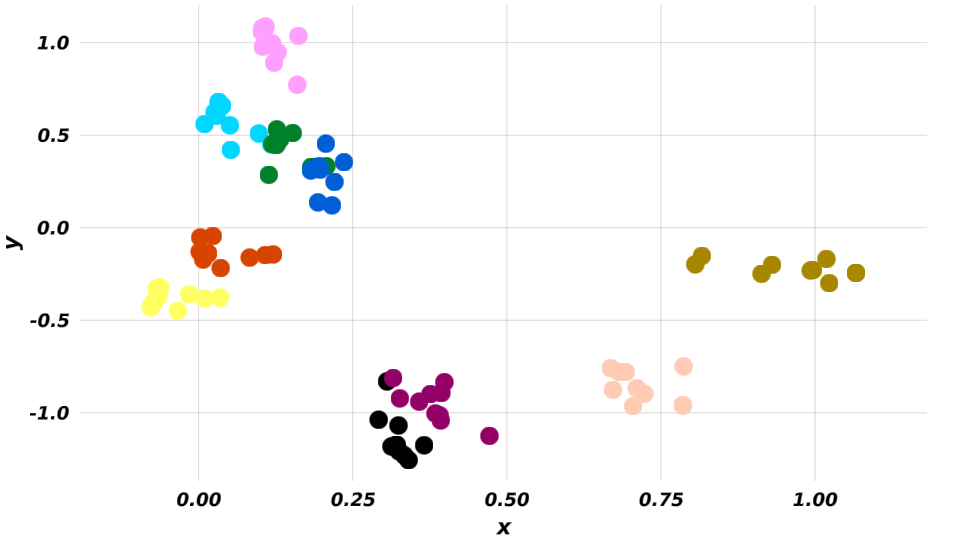

In [9]:
embμ, emblogσ = enc(features)
scene = Scene(resolution = (500, 500))
scatter(embμ[1, :], embμ[2, :], color = colors)

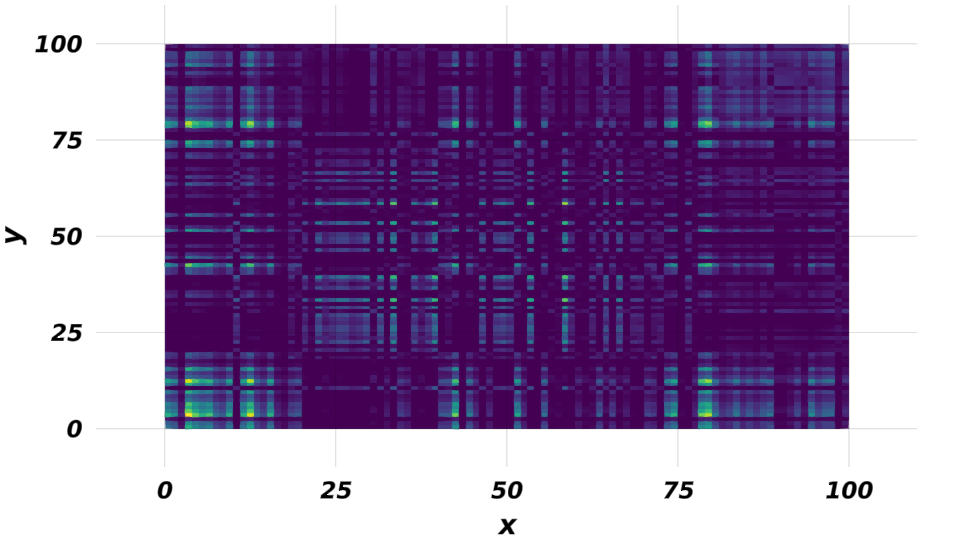

In [10]:
scene = Scene(resolution = (500, 500))
heatmap(vae(features).data)

In [11]:
logitbinarycrossentropy(logŷ, y; pos_weight = 1) = (1 - y) * logŷ + (1 + (pos_weight - 1) * y) * (log(1 + exp(-abs(logŷ))) + max(-logŷ, 0))

logitbinarycrossentropy (generic function with 1 method)

In [36]:
# TODO: check ref_api implementation details
regdec() = 0.01 * sum(x -> sum(x.^2), params(dec))
Lkl(μ, logσ) = 0.5 * sum(exp.(2 .* logσ) + μ.^2 .- 1 .- 2 .* logσ)
Adiag = Layers.adjacency_matrix_diag(g)
densityA = mean(adjacency_matrix(g))
La(ξ) = 0.5 * sum(logitbinarycrossentropy.(dec(ξ), Adiag, pos_weight = (1 / densityA) - 1)) / (1 - densityA)
#Lf(x) =
function loss(x)
    μ, logσ = enc(x)
    ξ = sampleξ(μ, logσ)
    Lkl(μ, logσ) * 1e-3 / (size(g, 1) * dimξ) + La(ξ) / (size(g, 1)^2 * log(2)) + 1e-3 * regdec()
end

evalcb = Flux.throttle(() -> @show(loss(features)), 5)
opt = ADAM(params(l1, lμ, llogσ, dec), 0.01)
Juno.@progress for i = 1:50000
  #@info "Epoch $i"
  Flux.train!(loss, zip([features]), opt, cb=evalcb)
end

loss(features) = 0.9209616984046113 (tracked)
loss(features) = 0.8321222059319484 (tracked)
loss(features) = 0.8314079168376466 (tracked)
loss(features) = 0.8310940730769656 (tracked)
loss(features) = 0.8308966151813956 (tracked)
loss(features) = 0.8304097576540231 (tracked)
loss(features) = 0.8310001091267172 (tracked)
loss(features) = 0.8307247014750483 (tracked)
loss(features) = 0.8304282101489301 (tracked)
loss(features) = 0.8302814822197593 (tracked)
loss(features) = 0.8306563403041131 (tracked)
loss(features) = 0.8304342808868413 (tracked)
loss(features) = 0.8305324760261807 (tracked)
loss(features) = 0.8307280437090713 (tracked)
loss(features) = 0.8302409625676798 (tracked)
loss(features) = 0.8306088456957481 (tracked)
loss(features) = 0.830462612675676 (tracked)
loss(features) = 0.8302584989750837 (tracked)
loss(features) = 0.8301502523281128 (tracked)
loss(features) = 0.8303168472866644 (tracked)
loss(features) = 0.830069351933697 (tracked)
loss(features) = 0.8300499787223442 

In [37]:
Lkl(enc(features)...)

875.8021149795286 (tracked)

In [38]:
La(sampleξ(enc(features)...))

5725.384568732549 (tracked)

In [39]:
loss(features)

0.8300517232082076 (tracked)

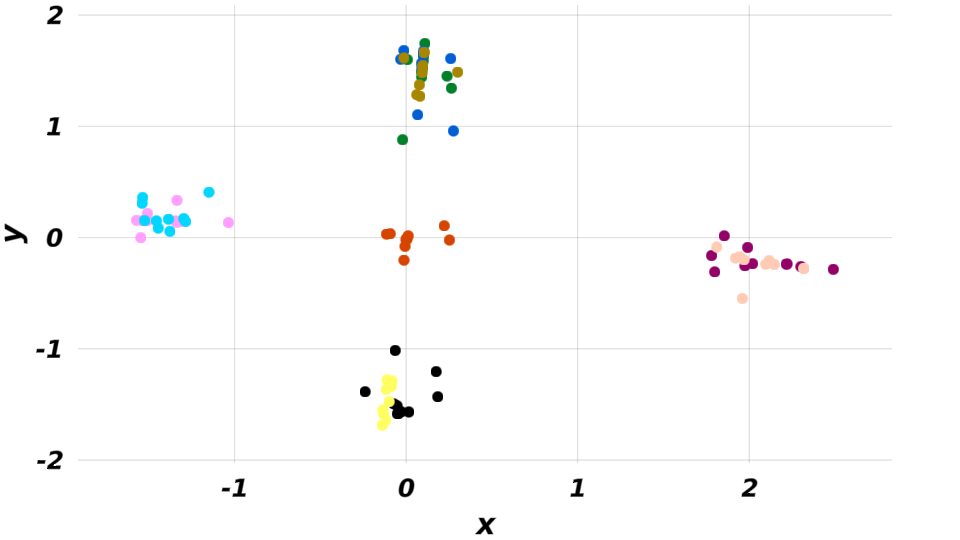

In [40]:
embμ, emblogσ = enc(features)
scene = Scene(resolution = (500, 500))
scatter(embμ[1, :], embμ[2, :], color = colors)

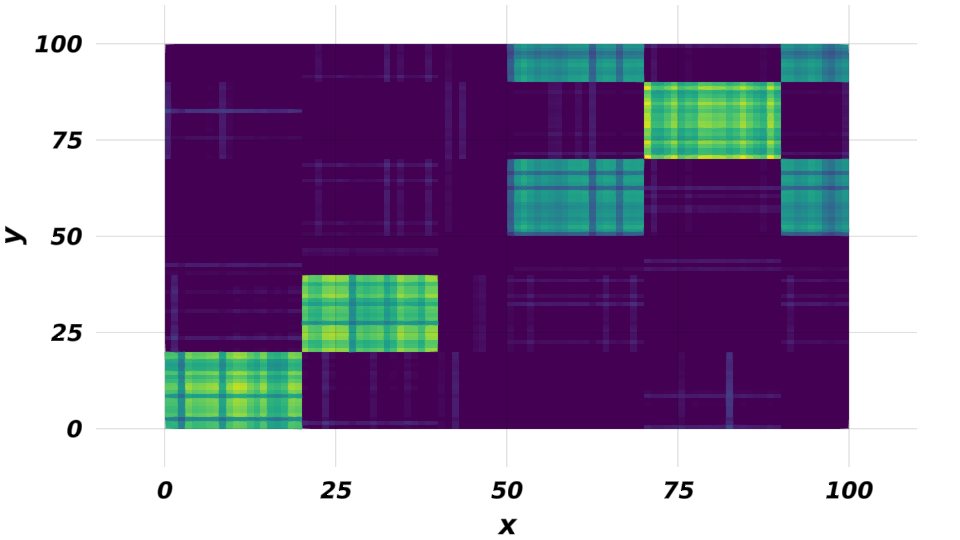

In [41]:
scene = Scene(resolution = (500, 500))
heatmap(vae(features).data)